# Optimize Inference on a Llama 3.2 1B on Pytorch

To start with, some imports will be made.

In [1]:
import time
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

Define the model ID and use the transformers utilities to load model and tokenizer from the Hugging Face hub.

In [2]:
model_id = "meta-llama/Llama-3.2-1B"
model = AutoModelForCausalLM.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)
# Setting `pad_token_id` to `eos_token_id` for open-end generation.
model.generation_config.pad_token_id = tokenizer.eos_token_id

Note no particular parameters have been used, meaning this will be loaded on CPU with FP32 precision.

In [3]:
print(f"Model dtype: {model.dtype} device: {model.device}")

Model dtype: torch.float32 device: cpu


Define a function to evaluate the inference time and run it once.

In [4]:
def inference_time(model, input_text):
    input_ids = tokenizer(input_text, return_tensors="pt").to(model.device)
    # Warm-up: first inference is slower
    model.generate(**input_ids, max_length=100)
    start = time.time()
    with torch.no_grad():
        output = model.generate(**input_ids, max_length=100)
    end = time.time()
    print(f"Output: {tokenizer.decode(output[0], skip_special_tokens=True)}")
    return end - start

input_text = "Once upon a time, a scientist"
times = {}
elapsed = inference_time(model, input_text)
print(f"Elapsed time: {elapsed:.2f} seconds")
times["cpu"] = elapsed

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Output: Once upon a time, a scientist named Charles Darwin hypothesized that the earth had once been inhabited by dinosaurs. The theory was that the dinosaurs were a type of reptile that lived on earth, and were the ancestors of all other animals. Scientists have since found evidence that supports this theory, and now we know that dinosaurs were once the dominant species on earth.
In this article, we will explore the evidence that supports the theory that dinosaurs were once the dominant species on earth. We will also look
Elapsed time: 7.47 seconds


Now move the model to the device (in this case, on a MacBook, it will be Metal Performance Shaders, on a setup with GPU it would be CUDA) and evaluate inference changes.

In [5]:
device = "mps"
model.to(device)
print(f"Model dtype: {model.dtype} device: {model.device}\n")

old_elapsed = elapsed
elapsed = inference_time(model, input_text)
print(f"Elapsed time: {elapsed:.2f} seconds, difference: {elapsed - old_elapsed:.2f} seconds")
times["mps 32b"] = elapsed

Model dtype: torch.float32 device: mps:0

Output: Once upon a time, a scientist discovered a drug that could cure the disease of the moment. The drug was effective, but it was very expensive, so no one wanted to pay for it. The drug was not effective for a second disease, so the scientist made a new drug that worked for the second disease, but it was also very expensive. The drug was not effective for a third disease, so the scientist made a new drug that worked for the third disease, but it was also very
Elapsed time: 7.51 seconds, difference: 0.03 seconds


Now reduce weights precision to `float16`, bacause MPS is capable of accelerating operations with this precision.

In [6]:
model.to(torch.float16)
print(f"Model dtype: {model.dtype} device: {model.device}\n")

old_elapsed = elapsed
elapsed = inference_time(model, input_text)
print(f"Elapsed time: {elapsed:.2f} seconds, difference: {elapsed - old_elapsed:.2f} seconds")
times["mps 16b"] = elapsed

Model dtype: torch.float16 device: mps:0

Output: Once upon a time, a scientist from the University of Washington in Seattle, Washington, was trying to find a way to increase the efficiency of solar panels. She wanted to make sure that more energy was collected from the sun, and that the solar panels were able to work for longer periods of time. To do this, she decided to make use of an old technology called “thermal mass,” which is a material that can store heat. The scientist had to find a way to use thermal mass to
Elapsed time: 4.91 seconds, difference: -2.60 seconds


## Quantization

Models can be quite big, and it can be challenging to keep them into memory. E.g.:

In [7]:

!du -sh `huggingface-cli scan-cache|grep Llama-3.2-1B|awk '{print $NF}'`

2.3G	/Users/amoran/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B


There are tools that allow to provide a simple quantization that will reduce weights footprint. Here it is possible to see how to achieve that using `optimum-quanto`.

In [8]:
from optimum.quanto import QuantizedModelForCausalLM, qint4

qmodel = QuantizedModelForCausalLM.quantize(model, weights=qint4, exclude='lm_head')
qmodel.save_pretrained('./Llama-3.2-1B-quantized')
!du -sh ./Llama-3.2-1B-quantized

997M	./Llama-3.2-1B-quantized


In this case the model size is next to 2.4 times smaller.
Note that performance can be quite slow though, unless a dedicated hardware is available.

In [9]:
qmodel.to(device)
elapsed = inference_time(qmodel, input_text)
print(f"Elapsed time: {elapsed:.2f} seconds, difference with MPS model: {elapsed - times['mps 32b']:.2f} seconds")
times["4-bit mps"] =  elapsed

Output: Once upon a time, a scientist called Albert Einstein discovered a mysterious particle called the “God Particle.” This particle was so small that it could fit inside a single atom. This particle was so powerful that it could create an entire universe in just a single second. This particle was so powerful that it could create an entire universe in just a single second. It was a particle that could create an entire universe in just a single second. It was a particle that could create an entire universe in just a
Elapsed time: 42.38 seconds, difference with MPS model: 34.87 seconds


## Visualize Performance Results

Text(0, 0.5, 'Evaluation time (s)')

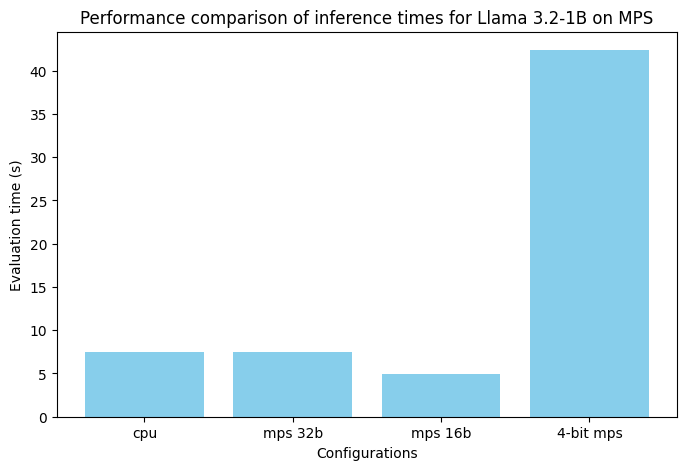

In [10]:
import matplotlib.pyplot as plt

x = list(times.keys())   # x-axis labels
y = list(times.values()) # y-axis values

# Create a bar graph
plt.figure(figsize=(8, 5))
plt.bar(x, y, color='skyblue')

# Add title and labels
plt.title('Performance comparison of inference times for Llama 3.2-1B on MPS')
plt.xlabel('Configurations')
plt.ylabel('Evaluation time (s)')